In [2]:
def convert_percentage_to_float(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: float(x.strip('%')) / 100 if isinstance(x, str) and '%' in x else x)
    return df

def to_numeric(s):
    if isinstance(s, (int,float)):
        return s
    # Remove unwanted characters
    cleaned = s.replace(',', '').replace('$', '').strip()
    if cleaned.replace('.', '').isdigit():  # If after removing '.' all characters are digits
        return float(cleaned) if '.' in cleaned else int(cleaned)
    return s  # If the string isn't numeric, return as is

def to_numeric_df(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str)
            df[col]= df[col].apply(to_numeric)
    return df

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/training_data/REVL COOF VALUATION 09-2023.csv')

df = df[[c for c in df.columns if 'unnamed' not in c.lower()]]
x = [c.replace('\n','') for c in df.columns]
x = [c.strip() for c in x]
x = [c.replace(' ','_') for c in x]
x = [c.lower() for c in x]
df.columns = x

df.dropna(how='all', inplace=True)


df['naics'] = df['naics'].fillna('0')

df['naics'] = df['naics'].astype(int)

df = convert_percentage_to_float(df)
df = to_numeric_df(df)

df['term_yrs']=df['term']//12


x_df = df[['naics','loan_spread','loan_rate','strip_rate','original_balance','current_balance','term_yrs','term','age','rmos']]
y_df = df['valuation_multiple']

X = x_df
y = y_df

def get_naics_dummies(in_df:pd.DataFrame)->pd.DataFrame:
    temp = in_df.copy()
    temp['is_hotel'] = 0
    temp.loc[temp['naics']==721110, 'is_hotel'] = 1
    temp.columns = [str(c) for c in temp.columns]
    return temp.drop(columns='naics')

# Create dummy columns with all the categories observed in the entire dataset
X = get_naics_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model = LinearRegression()

scaler = StandardScaler()

# This line isn't doing anything right now..
scaler.fit_transform(X_train, y_train)

print(X_train)

# Train the model on the training data
reg_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = reg_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

     loan_spread  loan_rate  strip_rate  original_balance  current_balance   
708       0.0175     0.1000     0.00730         605025.00        599249.59  \
239       0.0100     0.0925     0.00530         126558.60        126170.61   
381       0.0275     0.1100     0.01280         236667.97        235962.99   
792       0.0300     0.1125     0.02530         232187.55        232125.96   
672       0.0200     0.1025     0.01230        2925000.00       2923324.65   
..           ...        ...         ...               ...              ...   
106       0.0275     0.1100     0.03855        3698191.13       3682101.57   
270       0.0275     0.1100     0.01555         435963.02        434171.91   
860       0.0275     0.1100     0.02030         253812.59        253640.07   
435       0.0150     0.0975     0.01305        3580200.00       3580200.00   
102       0.0100     0.0925     0.00030        1034929.05       1029625.89   

     term_yrs        term        age        rmos  is_hotel  
70

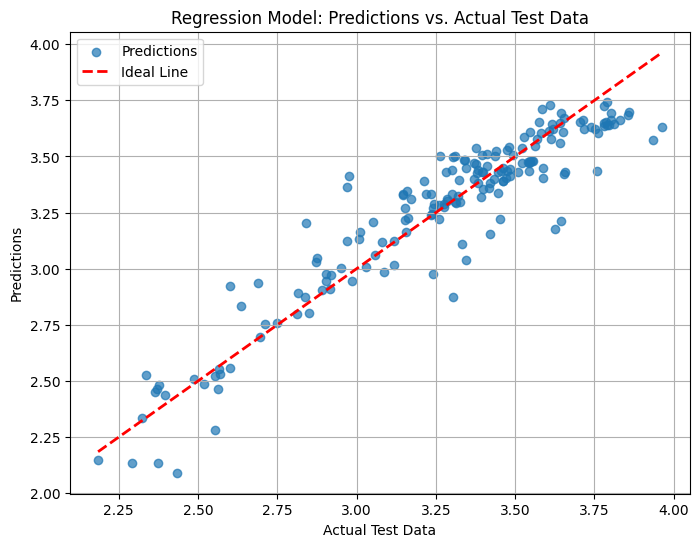

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the predictions vs the actual test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='Ideal Line')
plt.xlabel('Actual Test Data')
plt.ylabel('Predictions')
plt.title('Regression Model: Predictions vs. Actual Test Data')
plt.legend()
plt.grid(True)
plt.show()


Feature Importance Data:
            Feature   Coefficient  Absolute_Coefficient
0               age -6.311849e+04          6.311849e+04
1              term  6.311846e+04          6.311846e+04
2              rmos -6.311846e+04          6.311846e+04
3         loan_rate  7.868851e+00          7.868851e+00
4       loan_spread -1.666266e+00          1.666266e+00
5        strip_rate -1.346576e+00          1.346576e+00
6          is_hotel -2.222757e-01          2.222757e-01
7          term_yrs  6.245904e-02          6.245904e-02
8   current_balance -2.911217e-07          2.911217e-07
9  original_balance  2.839859e-07          2.839859e-07


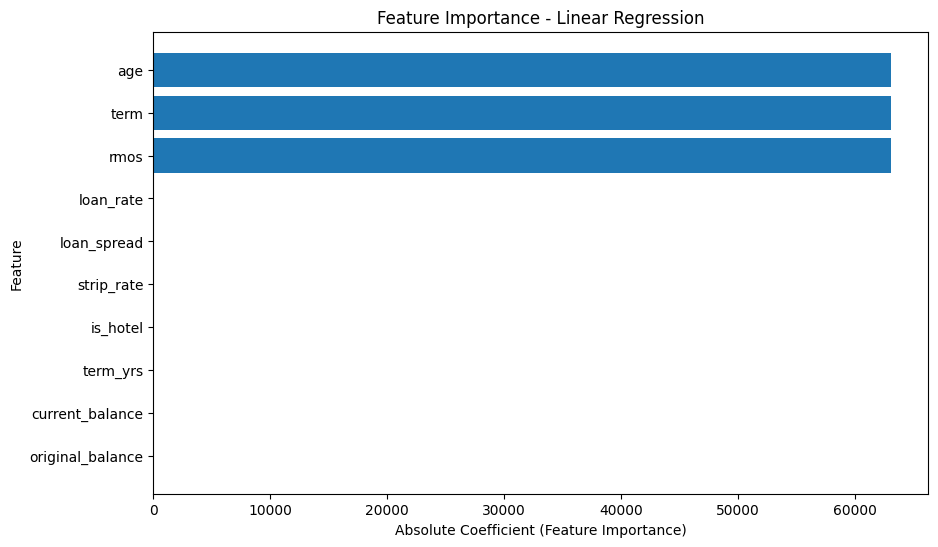

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already trained the 'reg_model' linear regression model

# Get the coefficients (weights) of the linear regression model
coefficients = reg_model.coef_

# Get the feature names
feature_names = X.columns

# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Calculate the absolute coefficients (feature importance)
feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()

# Sort the features based on their absolute coefficients to get feature importance
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False).reset_index(drop=True)

# Display the DataFrame containing feature importance data
print("Feature Importance Data:")
print(feature_importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Absolute_Coefficient'])
plt.xlabel('Absolute Coefficient (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance - Linear Regression')
plt.gca().invert_yaxis()
plt.show()


## Input new file to make predictions on below:

In [20]:
import sqlalchemy as sa

import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
load_dotenv()

engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
    .format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))

col_order = X.columns    
val_gps = pd.read_csv('../data/RJ142.csv')

val_gps_1 = val_gps[val_gps.columns[1:]]

val_gps_1['is_hotel'] = 0

val_gps_1.loc[val_gps_1['naics'] == ('721110'), 'is_hotel'] = 1

val_gps_1 = val_gps_1[val_gps_1.columns[1:]]

val_gps_1['term_yrs'] = val_gps_1['term'] // 12

val_gps_1 = val_gps_1[col_order]

naics_tbl = pd.read_csv('../data/naics_22/naics_lookup.csv')

val_gps = val_gps.merge(naics_tbl, left_on='naics', right_on='Code', how='left')
val_gps = val_gps.drop(columns=[c for c in val_gps.columns if 'unnamed' in c.lower()])
val_gps

,gp,naics,loan_rate,loan_spread,strip_rate,original_balance,current_balance,term,age,rmos,Code,CodeText
0,4169429107,624410,0.1000,0.0175,0.01040,340637.44,340637.44,303,14.136986,288.863014,624410.0,Child Care Services
1,4190879107,446199,0.0900,0.0000,0.01255,3618972.15,3618972.15,310,13.512329,296.487671,NaN,NaN
2,4648119105,312130,0.0950,0.0225,0.01525,273004.05,273004.05,300,9.106849,290.893151,312130.0,Wineries
3,4941869106,722513,0.0975,0.0100,0.00725,234891.86,234891.86,240,5.523288,234.476712,722513.0,Limited-Service Restaurants
4,5033609108,312120,0.0900,0.0175,0.02305,1557245.20,1557245.20,180,4.536986,175.463014,312120.0,Breweries
...,...,...,...,...,...,...,...,...,...,...,...,...
64,5339089110,624410,0.1075,0.0250,0.01480,541275.00,541275.00,300,0.197260,299.802740,624410.0,Child Care Services
65,5308359105,445298,0.1075,0.0150,0.00480,2025000.00,2025000.00,300,0.197260,299.802740,445298.0,All Other Specialty Food Retailers
66,5354389104,447110,0.1075,0.0200,0.01530,450000.00,450000.00,299,0.164384,298.835616,NaN,NaN
67,5362419100,445110,0.1075,0.0225,0.01230,2328750.00,2328750.00,299,0.131507,298.868493,445110.0,Supermarkets and Other Grocery Retailers (exce...


In [21]:
val_pred = reg_model.predict(val_gps_1)

In [22]:
val_gps['predicted_mult'] = val_pred

In [24]:
val_gps.to_csv('../data/predictions/rj142.csv')

In [23]:
val_gps[val_gps['CodeText'].isna()]

,gp,naics,loan_rate,loan_spread,strip_rate,original_balance,current_balance,term,age,rmos,Code,CodeText,predicted_mult
1,4190879107,446199,0.0900,0.000,0.01255,3618972.15,3618972.15,310,13.512329,296.487671,NaN,NaN,3.238060
16,5165049108,447110,0.1000,0.020,0.02305,884250.00,884250.00,180,1.282192,178.717808,NaN,NaN,2.966805
18,5213719103,623310,0.0975,0.015,0.02205,1080000.00,1080000.00,300,2.301370,297.698630,NaN,NaN,3.620409
23,5265939101,811113,0.0950,0.010,0.01705,3750000.00,3750000.00,300,1.117808,298.882192,NaN,NaN,3.630003
24,5274869106,445310,0.1025,0.020,0.02705,390675.00,390675.00,300,1.347945,298.652055,NaN,NaN,3.676593
35,5342539104,623310,0.1200,0.015,0.00480,683250.00,683250.00,300,0.427397,299.572603,NaN,NaN,3.881956
44,4919969105,447110,0.1000,0.015,0.00480,3750000.00,3750000.00,300,1.512329,298.487671,NaN,NaN,3.668530
45,5207409108,447110,0.0950,0.015,0.00480,873750.00,873750.00,300,1.939726,298.060274,NaN,NaN,3.632639
66,5354389104,447110,0.1075,0.020,0.01530,450000.00,450000.00,299,0.164384,298.835616,NaN,NaN,3.707789


In [17]:
import pickle
from joblib import dump, load
import joblib

# dump(reg_model,'../../../../package_analyzer/app/valuation/prod_reg_model.joblib')

joblib.__version__



'1.3.1'

In [19]:
val_gps.loc[val_gps['naics']==447110,'CodeText'] = 'Gasoline Stations with Convenience Stores'
val_gps.loc[val_gps['naics']==445310,'CodeText'] = 'Beer, Wine, and Liquor Stores'
val_gps.loc[val_gps['naics']==811100,'CodeText'] = 'Not a Valid NAICS Code'
val_gps.loc[val_gps['naics']==457117,'CodeText'] = 'Not a Valid NAICS Code'
val_gps.loc[val_gps['naics']==0,'CodeText'] = 'Not a Valid NAICS Code'


In [19]:
val_gps

,gp,naics,loan_spread,loan_rate,strip_rate,original_balance,current_balance,term,age,rmos,Code,CodeText,predicted_mult
0,3382849109,562998,0.0175,0.1000,0.02405,3480266.73,3376628.57,120.065753,17.227397,102.838356,562998.0,All Other Miscellaneous Waste Management Servi...,2.347827
1,4229189110,713990,0.0150,0.0975,0.02155,1807500.00,1782881.88,129.073973,11.967123,117.106849,713990.0,All Other Amusement and Recreation Industries,2.516227
2,1663059105,212311,0.0200,0.1025,0.02855,2499313.54,2447183.46,144.098630,20.679452,123.419178,212311.0,Dimension Stone Mining and Quarrying,2.343340
3,7246599001,562910,0.0275,0.1100,0.03955,2799425.31,2754385.04,168.098630,26.334247,141.764384,562910.0,Remediation Services,2.329098
4,4121929105,456110,0.0175,0.1000,0.02405,1378525.29,1356688.31,168.131507,14.005479,154.126027,456110.0,Pharmacies and Drug Retailers,2.674793
...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,4650219110,445320,0.0200,0.1025,0.02655,1194172.54,1187465.74,120.098630,6.147945,113.950685,445320.0,"Beer, Wine, and Liquor Retailers",2.626172
748,4547989109,449122,0.0200,0.1025,0.02855,1513870.30,1505147.48,120.098630,8.317808,111.780822,449122.0,Window Treatment Retailers,2.553892
749,4400849108,524210,0.0200,0.1025,0.02855,2480041.83,2465346.77,120.000000,9.000000,111.000000,524210.0,Insurance Agencies and Brokerages,2.522679
750,4341969108,561491,0.0100,0.0925,0.01655,2657504.91,2644015.83,120.098630,9.830137,110.268493,561491.0,Repossession Services,2.445934
